
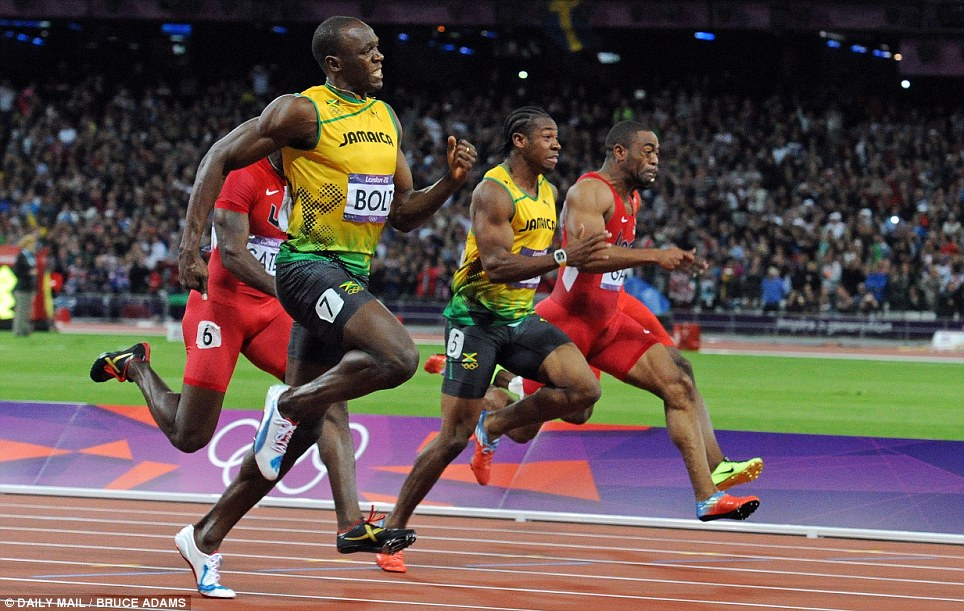

# Imports


In [1]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import time
import os
import seaborn as sns
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
import requests

# Collect data from web pages
when trying to use crawler we got blocked by the wed site so we chose to download the html pages then use our crawler to get the necessary data .
Since we download 2 different tables we build a function to prevent code duplication.  

In [2]:
#Bring the data from the U20 tables 
U20 = ["U20-1.html","U20-2.html","U20-3.html"]

#Bring the data from the Senior tables 
Senior = ["Senior1.html",
       "Senior2.html",
       "Senior3.html",
       "Senior4.html",
       "Senior5.html",
       "Senior6.html",
       "Senior7.html",
       "Senior8.html",
       "Senior9.html",
       "Senior10.html"]

def createDataFrame(PageList):
    rank = list()
    mark = list()
    wind= list()
    competitor= list()
    dob= list()
    nat= list()
    pos= list()
    venue= list()
    date= list()
    resultScore= list()
    html_SoupList=list()
    hrefList = list()
    for i in range(len(PageList)):
        soup=BeautifulSoup(open(PageList[i],encoding="utf8"),"html.parser")
        html_SoupList.append(soup)
        
    for j in range(len(PageList)):
        page = html_SoupList[j].find("tbody")
        
        for runner in page.find_all("tr"):
            rank.append(runner.find("td",{"data-th":"Rank"}).get_text(strip=True))
            mark.append(runner.find("td",{"data-th":"Mark"}).get_text(strip=True))
            wind.append(runner.find("td",{"data-th":"WIND"}).get_text(strip=True))
            competitor.append(runner.find("td",{"data-th":"Competitor"}).get_text(strip=True))
            dob.append(runner.find("td",{"data-th":"DOB"}).get_text(strip=True))
            nat.append(runner.find("td",{"data-th":"Nat"}).get_text(strip=True))
            pos.append(runner.find("td",{"data-th":"Pos"}).get_text(strip=True))
            venue.append(runner.find("td",{"data-th":"Venue"}).get_text(strip=True))
            date.append(runner.find("td",{"data-th":"Date"}).get_text(strip=True))
            resultScore.append(runner.find("td",{"data-th":"ResultScore"}).get_text(strip=True))  
            a = runner.find("td",{"data-th":"Competitor"}).find("a",href=True)
            hrefList.append(a['href'])
            
  #Create dataFrame
    data={'Rank':rank,
      'Mark':mark,
      'Wind':wind,
      'Competitor':competitor,
      'Age':dob,
      'Nat':nat,
      'Pos':pos,
      'Venue':venue,
      'Date':date,
      'ResultScore':resultScore,
      'href':hrefList}

    return pd.DataFrame(data)
    

In [3]:
# Create 2 DataFrame using function we build

df_U20 = createDataFrame(U20)
df_Senior = createDataFrame(Senior)


### Download all personal pages of the runners in the dataframe

We create another dataframe the contains all progress of runner we choses to take the first 500 runners that will give up 4500+ rows to work on.

In [4]:
#Method 1 to bring all 1000 runners personal pages 

# #imports 
# from selenium import webdriver
# from bs4 import BeautifulSoup

# counter=1
# #Getting all href from my dataframe 
# for link in df_Senior.href:
#     browser = webdriver.Firefox()
    
#     browser.get('https://www.worldathletics.org'+link)
#     content = browser.page_source
#     #setting uniqe id for each page i download
#     s="senior"+str(counter)  
#    #set a delay 
#     sleep(5)
#     #save the file 
#     with open(counter,'w+') as f:
#         f.write(s+'.html')
#         counter+=1


#------------------------------------------------------------------------------------------------

#Method 2

# import urllib.request
# counter=0
# for link in df_Senior.href:
#     s="senior"+str(counter)   
#     urllib.request.urlretrieve ('https://www.worldathletics.org'+link,s+".html")
#     counter+=1
#     sleep(5)

In [5]:
#Create page list location array 
def createPersonalPageList():
    counter = 0
    personalPageLocation = list()
    for i in range(500):
        s="data/senior"+str(counter)+".html"
        personalPageLocation.append(s)
        counter+=1
    return personalPageLocation


In [6]:
import re

def createDateFrameProgress(PageList):
    code=list()
    year=list()
    mark = list()
    wind= list()
    competitor= list()
    date= list()
    venue= list()
    html_SoupList=list()
    size = len(PageList)
    name=np.nan
    for i in range(size):
        soup=BeautifulSoup(open(PageList[i],encoding="utf8"),"html.parser")
        html_SoupList.append(soup)
     
    for j in range(size):
        proggression= html_SoupList[j].find("div",{"id":"progression"})
        table=proggression.find("tbody")
        # getting the name of the runner
        name = html_SoupList[j].find("h1").get_text(strip=True) 
        # getting the runner id 
        try:
            runnerCode=html_SoupList[j].find("span",{"class":"_label _label--athlete-id"}).get_text(strip=True)
            num = re.findall('\d+', str(runnerCode))  
        except:
            runnerCode = np.nan
            num = ['']
         
    
        for row in table.find_all("tr"):
                competitor.append(name)
                code.append(num[0])
                year.append(row.find("td",{"data-th":" "}).get_text(strip=True))
                mark.append(row.find("td",{"data-th":"Performance"}).get_text(strip=True))
                wind.append(row.find("td",{"data-th":"Wind"}).get_text(strip=True))
                date.append(row.find("td",{"data-th":"Date"}).get_text(strip=True))
                venue.append(row.find("td",{"data-th":"Place"}).get_text(strip=True))
                
  #Create dataFrame
    data={'Competitor':competitor,
          'Code':code,
          'Mark':mark,
          'Wind':wind,
          'Year':year,
          'Venue':venue,
          'Date':date,}

    return pd.DataFrame(data)

In [7]:
#create list of personal page location to fetch data from them 
personalPages = createPersonalPageList()

progress_df = createDateFrameProgress(personalPages)

# Checking data integrity (df_U20)

we going to use the following function in order to check data integrity.

1. describe(include='all') - see overall data count, unique , top , freq
2. isna().sum() - see if there is any missing data (nans)
3. info() - see what the types of the objects 
4. duplicated() - see if there are any duplicate

In [8]:
df_U20

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href
0,1,9.97,+1.8,Trayvon BROMELL,10 JUL 1995,USA,1,"Eugene, OR (USA)",13 JUN 2014,1217,https://www.worldathletics.org/athletes/athlet...
1,2,10.00,+1.6,Trentavis FRIDAY,05 JUN 1995,USA,1h1,"Eugene, OR (USA)",05 JUL 2014,1206,https://www.worldathletics.org/athletes/athlet...
2,3,10.01,0.0,Darrel BROWN,11 OCT 1984,TTO,1qf3,"Stade de France, Paris-St-Denis (FRA)",24 AUG 2003,1203,https://www.worldathletics.org/athletes/athlet...
3,3,10.01,+1.6,Jeff DEMPS,08 JAN 1990,USA,2qf1,"Eugene, OR (USA)",28 JUN 2008,1203,https://www.worldathletics.org/athletes/athlet...
4,3,10.01,+0.9,Yoshihide KIRYU,15 DEC 1995,JPN,1h3,Hiroshima (JPN),28 APR 2013,1203,https://www.worldathletics.org/athletes/athlet...
...,...,...,...,...,...,...,...,...,...,...,...
282,263,10.30,+1.7,TJ BROCK,03 FEB 1998,USA,2h3,"Austin, TX (USA)",30 MAR 2017,1105,/athletes/united-states/tj-brock-014641174
283,263,10.30,+1.9,Yusuke TANAKA,11 JAN 1998,JPN,2,Hiratsuka (JPN),10 JUN 2017,1105,/athletes/athlete=320096
284,263,10.30,+1.5,Michael BENTLEY,17 JAN 1999,JAM,1,Kingston (JAM),22 JUN 2018,1105,/athletes/athlete=297368
285,263,10.30,+1.2,Kenan CHRISTON,,USA,1,"Clovis, CA (USA)",25 MAY 2019,1105,/athletes/athlete=396899


In [9]:
# changing the missing values into nan 
df_U20.replace('',np.nan,inplace=True)

In [10]:
df_U20.describe(include='all')

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href
count,287,287,267,287,279,287,287,287,287,287,287
unique,31,31,34,287,272,42,48,164,245,44,287
top,191,10.27,+2.0,Arnaldo L. ROMERO,06 APR 1984,USA,1,Kingston (JAM),21 JUL 1994,1105,/athletes/athlete=170931
freq,26,26,28,1,2,120,127,16,4,24,1


In [11]:
# we can see that there is no missing data and all of the types non-null object
df_U20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 11 columns):
Rank           287 non-null object
Mark           287 non-null object
Wind           267 non-null object
Competitor     287 non-null object
Age            279 non-null object
Nat            287 non-null object
Pos            287 non-null object
Venue          287 non-null object
Date           287 non-null object
ResultScore    287 non-null object
href           287 non-null object
dtypes: object(11)
memory usage: 24.8+ KB


In [12]:
# Checking duplicated if there are duplication it will show up here as we can see there are no duplications.
df_U20[df_U20.duplicated()]

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href


In [13]:
#we can see Age is Date of birth 
df_U20.Age

0      10 JUL 1995
1      05 JUN 1995
2      11 OCT 1984
3      08 JAN 1990
4      15 DEC 1995
          ...     
282    03 FEB 1998
283    11 JAN 1998
284    17 JAN 1999
285            NaN
286    11 OCT 2001
Name: Age, Length: 287, dtype: object

In [14]:
#changing the Date type into time object
df_U20.Age = pd.to_datetime(df_U20.Age)
df_U20.Age

0     1995-07-10
1     1995-06-05
2     1984-10-11
3     1990-01-08
4     1995-12-15
         ...    
282   1998-02-03
283   1998-01-11
284   1999-01-17
285          NaT
286   2001-10-11
Name: Age, Length: 287, dtype: datetime64[ns]

In [15]:
#this function calculate Age
from datetime import date 
  
def calculateAge(birthDate): 
    today = date.today() 
    age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day)) 
           
    return age 
      
#Change all Date of birth into Ages  
df_U20.Age=df_U20.Age.apply(calculateAge)

In [16]:
#we can see the Date change into age by years
df_U20

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href
0,1,9.97,+1.8,Trayvon BROMELL,25.0,USA,1,"Eugene, OR (USA)",13 JUN 2014,1217,https://www.worldathletics.org/athletes/athlet...
1,2,10.00,+1.6,Trentavis FRIDAY,25.0,USA,1h1,"Eugene, OR (USA)",05 JUL 2014,1206,https://www.worldathletics.org/athletes/athlet...
2,3,10.01,0.0,Darrel BROWN,35.0,TTO,1qf3,"Stade de France, Paris-St-Denis (FRA)",24 AUG 2003,1203,https://www.worldathletics.org/athletes/athlet...
3,3,10.01,+1.6,Jeff DEMPS,30.0,USA,2qf1,"Eugene, OR (USA)",28 JUN 2008,1203,https://www.worldathletics.org/athletes/athlet...
4,3,10.01,+0.9,Yoshihide KIRYU,24.0,JPN,1h3,Hiroshima (JPN),28 APR 2013,1203,https://www.worldathletics.org/athletes/athlet...
...,...,...,...,...,...,...,...,...,...,...,...
282,263,10.30,+1.7,TJ BROCK,22.0,USA,2h3,"Austin, TX (USA)",30 MAR 2017,1105,/athletes/united-states/tj-brock-014641174
283,263,10.30,+1.9,Yusuke TANAKA,22.0,JPN,2,Hiratsuka (JPN),10 JUN 2017,1105,/athletes/athlete=320096
284,263,10.30,+1.5,Michael BENTLEY,21.0,JAM,1,Kingston (JAM),22 JUN 2018,1105,/athletes/athlete=297368
285,263,10.30,+1.2,Kenan CHRISTON,NaN,USA,1,"Clovis, CA (USA)",25 MAY 2019,1105,/athletes/athlete=396899


In [17]:
#we can see how many values are missing 
df_U20.isna().sum()

Rank            0
Mark            0
Wind           20
Competitor      0
Age             8
Nat             0
Pos             0
Venue           0
Date            0
ResultScore     0
href            0
dtype: int64

# Handling Nan values

we can see there are 20 wind and 8 ages values that are currently nan .
1. In the wind section we decided to put the mean value of the wind in those empty places 
2. In the Age section we decided to  .......(need to fill here)


In [18]:
df_U20.iloc[10]

Rank                                                          11
Mark                                                       10.05
Wind                                                         NaN
Competitor                                       Davidson EZINWA
Age                                                           48
Nat                                                          NGR
Pos                                                            1
Venue                                               Bauchi (NGR)
Date                                                 03 JAN 1990
ResultScore                                                 1189
href           https://www.worldathletics.org/athletes/athlet...
Name: 10, dtype: object

In [19]:
df_U20.Wind=df_U20.Wind.astype(float)
meanWind = "%.1f" % df_U20.Wind.mean()
df_U20.Wind.fillna(meanWind,inplace=True)            

In [20]:
df_U20.iloc[10]

Rank                                                          11
Mark                                                       10.05
Wind                                                         1.0
Competitor                                       Davidson EZINWA
Age                                                           48
Nat                                                          NGR
Pos                                                            1
Venue                                               Bauchi (NGR)
Date                                                 03 JAN 1990
ResultScore                                                 1189
href           https://www.worldathletics.org/athletes/athlet...
Name: 10, dtype: object

In [21]:
#remove nans - only age have nans
df_U20.dropna(inplace=True)

# Checking data integrity (df_Senior)
we going to use the following function in order to check data integrity.
1. replace black square with np.nans to identify nans.
2. describe(include='all') - see overall data count, unique , top , freq
3. info() - see what the types of the objects 
4. duplicated() - see if there are any duplicate
5. change the date of birth into the Age today.
6. isna().sum() - see if there is any missing data (nans)


In [22]:
# changing the missing values into nan 
df_Senior.replace('',np.nan,inplace=True)

In [23]:
df_Senior.describe(include='all')

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href
count,1000,1000,965,1000,991,1000,1000,1000,1000,1000,1000
unique,48,48,38,998,953,100,96,392,685,82,1000
top,875,10.21,+1.9,Ryan CLARK,10 SEP 1981,USA,1,"Eugene, OR (USA)",28 JUN 2008,1135,/athletes/athlete=130121
freq,88,88,69,2,3,342,328,32,10,84,1


In [24]:
# we can see that there is no missing data and all of the types non-null object
df_Senior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
Rank           1000 non-null object
Mark           1000 non-null object
Wind           965 non-null object
Competitor     1000 non-null object
Age            991 non-null object
Nat            1000 non-null object
Pos            1000 non-null object
Venue          1000 non-null object
Date           1000 non-null object
ResultScore    1000 non-null object
href           1000 non-null object
dtypes: object(11)
memory usage: 86.1+ KB


In [25]:
# Checking duplicated if there are duplication it will show up here as we can see there are no duplications.
df_Senior[df_Senior.duplicated()]

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href


In [26]:
#changing the Date type into time object
df_Senior.Age = pd.to_datetime(df_Senior.Age)
df_Senior.Date = pd.to_datetime(df_Senior.Date)
df_Senior.Age

0     1986-08-21
1     1982-08-09
2     1989-12-26
3     1982-11-23
4     1982-02-10
         ...    
995   1974-04-21
996   1979-12-26
997   1978-05-14
998   1981-11-07
999   1981-09-10
Name: Age, Length: 1000, dtype: datetime64[ns]

In [27]:
#Change all Date of birth into Ages  
df_Senior.Age=df_Senior.Age.apply(calculateAge)

In [28]:
df_Senior

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href
0,1,9.58,+0.9,Usain BOLT,33.0,JAM,1,"Olympiastadion, Berlin (GER)",2009-08-16,1356,/athletes/athlete=184599
1,2,9.69,+2.0,Tyson GAY,37.0,USA,1,Shanghai (CHN),2009-09-20,1316,/athletes/athlete=185464
2,2,9.69,-0.1,Yohan BLAKE,30.0,JAM,1,"Pontaise, Lausanne (SUI)",2012-08-23,1316,/athletes/athlete=208640
3,4,9.72,+0.2,Asafa POWELL,37.0,JAM,1f1,"Pontaise, Lausanne (SUI)",2008-09-02,1305,/athletes/athlete=189571
4,5,9.74,+0.9,Justin GATLIN,38.0,USA,1,"Hamad Bin Suhaim, Doha (QAT)",2015-05-15,1298,/athletes/athlete=176453
...,...,...,...,...,...,...,...,...,...,...,...
995,963,10.22,NaN,Philip MUKOMANA,46.0,ZIM,2,Harare (ZIM),2001-06-03,1132,/athletes/athlete=130121
996,963,10.22,+1.6,Kenji NARA,40.0,JPN,1,Kitakami (JPN),2001-07-14,1132,/athletes/athlete=134076
997,963,10.22,+1.7,Marco TORRIERI,42.0,ITA,1,Roma (ITA),2002-06-01,1132,/athletes/athlete=137250
998,963,10.22,+1.6,Fabrice CALLIGNY,38.0,FRA,3,St-Etienne (FRA),2002-07-13,1132,/athletes/athlete=172423


In [29]:
df_Senior.isna().sum()

Rank            0
Mark            0
Wind           35
Competitor      0
Age             9
Nat             0
Pos             0
Venue           0
Date            0
ResultScore     0
href            0
dtype: int64

# Handling Nan values

we can see there are 20 wind and 8 ages values that are currently nan .
1. In the wind section we decided to put the mean value of the wind in those empty places 
2. In the Age section we decided to  remove all nan rows since there are only 9 from 1000 


In [30]:
df_Senior.Wind=df_Senior.Wind.astype(float)
meanWind = "%.1f" % df_Senior.Wind.mean()

df_Senior.Wind.fillna(meanWind,inplace=True)         

In [31]:
#remove nans - only age have nans
df_Senior.dropna(inplace=True)

# Checking data integrity (progress_df)
we going to use the following function in order to check data integrity.
1. replace blank square with np.nans to identify nans.
2. describe(include='all') - see overall data count, unique , top , freq
3. info() - see what the types of the objects 
5. isna().sum() - see if there is any missing data (nans)


In [32]:
progress_df.head()

,Competitor,Code,Mark,Wind,Year,Venue,Date
0,Usain BOLT,14201847,9.95,+0.7,2017,"Stade Louis II, Monaco (MON)",21 JUL 2017
1,Usain BOLT,14201847,9.81,+0.2,2016,"Estádio Olímpico, Rio de Janeiro (BRA)",14 AUG 2016
2,Usain BOLT,14201847,9.79,-0.5,2015,"National Stadium, Beijing (CHN)",23 AUG 2015
3,Usain BOLT,14201847,9.98,-0.6,2014,Warszawa (POL),23 AUG 2014
4,Usain BOLT,14201847,9.77,-0.3,2013,"Luzhniki, Moskva (RUS)",11 AUG 2013


In [33]:
progress_df.replace('',np.nan,inplace=True)

In [34]:
progress_df.describe(include='all')

,Competitor,Code,Mark,Wind,Year,Venue,Date
count,4494,4473,4494,4321,4494,4494,4494
unique,500,493,193,56,51,908,2140
top,Francis OBIKWELU,14218403,10.12,0.0,2016,Kingston (JAM),11 JUN 2016
freq,25,25,113,296,205,170,22


In [35]:
progress_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4494 entries, 0 to 4493
Data columns (total 7 columns):
Competitor    4494 non-null object
Code          4473 non-null object
Mark          4494 non-null object
Wind          4321 non-null object
Year          4494 non-null object
Venue         4494 non-null object
Date          4494 non-null object
dtypes: object(7)
memory usage: 245.9+ KB


In [36]:
progress_df.isna().sum()

Competitor      0
Code           21
Mark            0
Wind          173
Year            0
Venue           0
Date            0
dtype: int64

In [37]:
progress_df.Wind = progress_df.Wind.astype(float)
meanWind = "%.1f" % progress_df.Wind.mean()
progress_df.Wind.fillna(meanWind,inplace=True)  

In [38]:
# we chose not to remove those runners since its only the runner code that is missing there for we can still use their data
progress_df[progress_df.Code.isna()]

,Competitor,Code,Mark,Wind,Year,Venue,Date
3376,Hans-Jürgen BOMBACH,NaN,10.41,0.8,1975,Dresden (GER),22 JUN 1975
3377,Hans-Jürgen BOMBACH,NaN,10.10,-1.1,1973,Berlin (GER),29 AUG 1973
3378,Hans-Jürgen BOMBACH,NaN,10.64,0,1972,"Olympiastadion, München (GER)",31 AUG 1972
3637,Robert WOODS,NaN,10.11,0.8,1977,"Austin, TX (USA)",02 APR 1977
3638,Robert WOODS,NaN,10.42,0.9,1976,"Westwood, CA (USA)",11 JUN 1976
3639,Curtis DICKEY,NaN,10.21,1.6,1980,San José (USA),12 APR 1980
3640,Curtis DICKEY,NaN,10.34,1.3,1979,"Des Moines, IA (USA)",28 APR 1979
3641,Curtis DICKEY,NaN,10.11,1.7,1978,"Eugene, OR (USA)",02 JUN 1978
3651,Don COLEMAN,NaN,10.15,1.6,1979,Merksem (BEL),21 JUN 1979
3652,Don COLEMAN,NaN,10.11,1.8,1978,Air Force Academy (USA),30 JUL 1978


# Adding information column(df_Senior)


In [39]:
df_Senior.Mark = df_Senior.Mark.astype(float)

df_Senior['Avg Speed kph'] = (100/df_Senior.Mark)* 3.60000

# Translate the date of record into the runner age to see in what age he broke the record
df_Senior['Record Age'] = df_Senior.Age - df_Senior.Date.apply(calculateAge)

# Adding information column(df_U20)

In [40]:
#changing the Date type into time object
df_U20.Date = pd.to_datetime(df_U20.Date)
df_U20.Age

0      25.0
1      25.0
2      35.0
3      30.0
4      24.0
       ... 
281    23.0
282    22.0
283    22.0
284    21.0
286    18.0
Name: Age, Length: 279, dtype: float64

In [41]:
df_U20.Mark = df_U20.Mark.astype(float)

df_U20['Avg Speed kph'] = (100/df_U20.Mark)* 3.60000

# Translate the date of record into the runner age to see in what age he broke the record
df_U20['Record Age'] = df_U20.Age - df_U20.Date.apply(calculateAge)

In [42]:
df_U20

,Rank,Mark,Wind,Competitor,Age,Nat,Pos,Venue,Date,ResultScore,href,Avg Speed kph,Record Age
0,1,9.97,1.8,Trayvon BROMELL,25.0,USA,1,"Eugene, OR (USA)",2014-06-13,1217,https://www.worldathletics.org/athletes/athlet...,36.108325,19.0
1,2,10.00,1.6,Trentavis FRIDAY,25.0,USA,1h1,"Eugene, OR (USA)",2014-07-05,1206,https://www.worldathletics.org/athletes/athlet...,36.000000,19.0
2,3,10.01,0,Darrel BROWN,35.0,TTO,1qf3,"Stade de France, Paris-St-Denis (FRA)",2003-08-24,1203,https://www.worldathletics.org/athletes/athlet...,35.964036,19.0
3,3,10.01,1.6,Jeff DEMPS,30.0,USA,2qf1,"Eugene, OR (USA)",2008-06-28,1203,https://www.worldathletics.org/athletes/athlet...,35.964036,18.0
4,3,10.01,0.9,Yoshihide KIRYU,24.0,JPN,1h3,Hiroshima (JPN),2013-04-28,1203,https://www.worldathletics.org/athletes/athlet...,35.964036,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,263,10.30,1.5,Hakim MONTGOMERY,23.0,USA,2,"Lafayette, LA (USA)",2016-05-15,1105,/athletes/athlete=310422,34.951456,19.0
282,263,10.30,1.7,TJ BROCK,22.0,USA,2h3,"Austin, TX (USA)",2017-03-30,1105,/athletes/united-states/tj-brock-014641174,34.951456,19.0
283,263,10.30,1.9,Yusuke TANAKA,22.0,JPN,2,Hiratsuka (JPN),2017-06-10,1105,/athletes/athlete=320096,34.951456,19.0
284,263,10.30,1.5,Michael BENTLEY,21.0,JAM,1,Kingston (JAM),2018-06-22,1105,/athletes/athlete=297368,34.951456,19.0


# Adding information column(progress_df)


In [43]:
# merging the 2 dataframe inorder to get the age of each competitor in progress df
mergedStuff = pd.merge(progress_df, df_Senior, on=['Competitor'], how='inner')
mergedStuff.drop("Pos",axis=1,inplace=True)
mergedStuff.drop("Mark_y",axis=1,inplace=True)
mergedStuff.drop("ResultScore",axis=1,inplace=True)
mergedStuff.drop("Venue_y",axis=1,inplace=True)
mergedStuff.drop("href",axis=1,inplace=True)
mergedStuff.drop("Avg Speed kph",axis=1,inplace=True)
mergedStuff.drop("Date_y",axis=1,inplace=True)
mergedStuff.drop("Wind_y",axis=1,inplace=True)


mergedStuff.rename(columns={"Mark_x": "Mark", "Wind_x": "Wind", "Venue_x": "Venue", "Date_x": "Date"}, errors="raise",inplace=True)
mergedStuff

,Competitor,Code,Mark,Wind,Year,Venue,Date,Rank,Age,Nat,Record Age
0,Usain BOLT,14201847,9.95,0.7,2017,"Stade Louis II, Monaco (MON)",21 JUL 2017,1,33.0,JAM,23.0
1,Usain BOLT,14201847,9.81,0.2,2016,"Estádio Olímpico, Rio de Janeiro (BRA)",14 AUG 2016,1,33.0,JAM,23.0
2,Usain BOLT,14201847,9.79,-0.5,2015,"National Stadium, Beijing (CHN)",23 AUG 2015,1,33.0,JAM,23.0
3,Usain BOLT,14201847,9.98,-0.6,2014,Warszawa (POL),23 AUG 2014,1,33.0,JAM,23.0
4,Usain BOLT,14201847,9.77,-0.3,2013,"Luzhniki, Moskva (RUS)",11 AUG 2013,1,33.0,JAM,23.0
...,...,...,...,...,...,...,...,...,...,...,...
4502,Fabio CERUTTI,14199915,10.13,-0.1,2008,Cagliari (ITA),19 JUL 2008,483,34.0,ITA,23.0
4503,Fabio CERUTTI,14199915,10.29,0.5,2007,Debrecen (HUN),12 JUL 2007,483,34.0,ITA,23.0
4504,Fabio CERUTTI,14199915,10.43,1.7,2006,Roma (ITA),17 JUN 2006,483,34.0,ITA,23.0
4505,Fabio CERUTTI,14199915,10.63,1.1,2005,Pavia (ITA),22 MAY 2005,483,34.0,ITA,23.0


In [44]:
mergedStuff.Date = pd.to_datetime(mergedStuff.Date)
mergedStuff.Mark = mergedStuff.Mark.astype(float)

mergedStuff['Avg Speed kph'] = (100/mergedStuff.Mark)* 3.60000

# Translate the date of record into the runner age to see in what age he broke the record
mergedStuff['Progress Age'] = mergedStuff.Age - mergedStuff.Date.apply(calculateAge)

In [45]:
progress_df=mergedStuff

In [46]:
# Some of the data were collected also on 60m runners 
progress_df[progress_df.Mark<=9.57].index

Int64Index([  44,   66,   67,   68,   69,  368,  523,  524,  525,  526,  690,
             705,  720,  721,  722,  723,  740,  781,  782,  783,  784,  890,
            1086, 1087, 1088, 1139, 1140, 1272, 1273, 1649, 1845, 1998, 2025,
            2402, 2601, 2666, 2667, 2878, 2879, 2880, 2896, 3076, 3077, 3078,
            3096, 3097, 3098, 3099, 3109, 3599, 3706, 3858, 3859, 3860, 3861,
            3862, 4143, 4201, 4202, 4203, 4222, 4223, 4310],
           dtype='int64')

In [47]:
# so we removed that data since bolt holds the record it is ez to know where the 60m runners are located and remove them 
progress_df.drop(
    labels=None,
    axis=0,
    index=progress_df[progress_df.Mark<=9.57].index,
    level=None,
    inplace=True,
    errors='raise'
)

# Save Data to csv
 After we save the data into 3 csv:

#### 1.seniors

#### 2.U20

#### 3.progress

 we will analyze the data, please go to the second file in the project of analyzed data


In [48]:
df_Senior.to_csv("df_senior.csv",index=False)
df_U20.to_csv("df_u20.csv",index=False)
progress_df.to_csv("df_progress.csv",index=False)